#Dans ce deuxième notebook, nous explorons différentes approches de modélisation non supervisée dans le but de segmenter les clients de KPMG’s en groupes cohérents selon leurs caractéristiques démographiques et comportementales. Après avoir nettoyé et préparé les données issues de notre analyse exploratoire (Notebook 1), nous mettons en œuvre plusieurs méthodes de clustering telles que K-Means, DBSCAN, Birch et le clustering hiérarchique, afin de comparer leurs performances et leur pertinence dans un contexte marketing. Chaque méthode est évaluée à l’aide de métriques internes comme le Silhouette Score, ainsi que par une interprétation métier des groupes formés. Ce notebook vise à identifier la méthode de segmentation la plus robuste, la plus exploitable et la plus facile à maintenir dans le temps pour les équipes de KPMG’s.

#Analyse exploratoire avec la gestion des incohérences

In [1]:
import pandas as pd
import numpy as np

# Charger le fichier Excel
excel_file = pd.ExcelFile("KPMG_dummy_data.xlsx")

# Nom des feuilles à traiter
sheets = ["Transactions", "NewCustomerList", "CustomerDemographic", "CustomerAddress"]

# Parcourir chaque feuille
for sheet_name in sheets:
    print(f"--- Analyse de la feuille {sheet_name} ---")

    # Charger la feuille
    df = excel_file.parse(sheet_name)

    # 1. Afficher un aperçu des 5 premières lignes
    print("\nAperçu des 5 premières lignes :")
    print(df.head())

    # 2. Vérifier et corriger les types de données

    # Supprimer la colonne 'default' si elle existe (spécifique à CustomerDemographic)
    if sheet_name == "CustomerDemographic" and 'default' in df.columns:
        print("\nSuppression de la colonne 'default' dans CustomerDemographic.")
        df = df.drop('default', axis=1)

    print("\nTypes de données avant correction :")
    print(df.dtypes)

    # Correction des types de données
    # Adapter ces conversions en fonction des colonnes réelles de votre fichier Excel
    for col in df.columns:
        # Tentative de convertir en numérique si possible (sauf les colonnes d'ID qui pourraient être des chaînes)
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            except:
                pass # Laisser comme objet si la conversion échoue

    # Correction spécifique pour les dates
    date_columns = ['transaction_date', 'DOB'] # noms de colonnes de date
    for date_col in date_columns:
        if date_col in df.columns:
            # Utiliser errors='coerce' pour convertir les valeurs invalides en NaT (Not a Time)
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    print("\nTypes de données après correction (après tentatives de conversion) :")
    print(df.dtypes)


    # 3. Repérer les valeurs manquantes et les remplacer par le mode

    print("\nGestion des valeurs manquantes :")
    missing_before = df.isnull().sum()
    print("Nombre de valeurs manquantes par colonne avant remplacement :")
    print(missing_before[missing_before > 0])

    columns_with_missing_replaced = []
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            # Calculer le mode
            # .mode() peut retourner plusieurs valeurs s'il y a égalité, on prend la première [0]
            # .dropna() pour ne pas inclure les NaN dans le calcul du mode
            mode_val = df[column].dropna().mode()
            if not mode_val.empty:
                fill_value = mode_val[0]
                df[column].fillna(fill_value, inplace=True)
                columns_with_missing_replaced.append(column)
                print(f"  - Remplacement des valeurs manquantes dans '{column}' par le mode ({fill_value}).")
            else:
                 print(f"  - La colonne '{column}' contient uniquement des valeurs manquantes ou des NaN, le mode n'a pas pu être calculé.")


    missing_after = df.isnull().sum()
    print("\nNombre de valeurs manquantes par colonne après remplacement :")
    print(missing_after[missing_after > 0]) # Afficher uniquement les colonnes qui pourraient encore avoir des NaN (si mode n'a pas pu être calculé)

    if columns_with_missing_replaced:
        print(f"\nColonnes où des valeurs manquantes ont été remplacées par le mode : {', '.join(columns_with_missing_replaced)}")
    else:
        print("\nAucune valeur manquante n'a été remplacée par le mode dans cette feuille.")


    # 4. Identifier et traiter les valeurs aberrantes (outliers)
    print("\nGestion des valeurs aberrantes (outliers) :")

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    print(f"\nColonnes numériques pour la détection d'outliers : {', '.join(numeric_cols)}")

    outliers_info = {}

    for col in numeric_cols:
        # Calcul de l'IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identifier les outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        if not outliers.empty:
            outliers_count = len(outliers)
            outliers_info[col] = {'count': outliers_count, 'lower_bound': lower_bound, 'upper_bound': upper_bound}
            print(f"  - Colonne '{col}': {outliers_count} outliers détectés. Bornes IQR: [{lower_bound:.2f}, {upper_bound:.2f}]")

            # Traitement des outliers : Remplacement par la borne la plus proche (Winsorizing simple)
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
            print(f"    Les outliers dans '{col}' ont été remplacés par les bornes IQR.")
        else:
            print(f"  - Colonne '{col}': Aucun outlier détecté par la méthode IQR.")

    if not numeric_cols:
        print("\nPas de colonnes numériques trouvées pour la détection d'outliers.")


    # 5. Afficher un résumé statistique des colonnes numériques
    print("\nRésumé statistique des colonnes numériques après traitement des outliers :")
    print(df.select_dtypes(include=np.number).describe())

    # 6. Commentaire synthétique
    print(f"\nCommentaire synthétique pour la feuille '{sheet_name}':")
    print(f"  - La feuille '{sheet_name}' contient {len(df)} lignes et {len(df.columns)} colonnes.")
    print(f"  - Les types de données ont été ajustés, en particulier pour les colonnes numériques et les dates.")

    if columns_with_missing_replaced:
        print(f"  - Des valeurs manquantes ont été remplacées par le mode dans les colonnes : {', '.join(columns_with_missing_replaced)}.")
    else:
        print("  - Aucune valeur manquante significative n'a été trouvée ou remplacée par le mode.")

    if outliers_info:
        outlier_cols_treated = list(outliers_info.keys())
        print(f"  - Des outliers ont été détectés et traités (remplacés par les bornes IQR) dans les colonnes numériques : {', '.join(outlier_cols_treated)}.")
        total_outliers_treated = sum([info['count'] for info in outliers_info.values()])
        print(f"  - Au total, environ {total_outliers_treated} valeurs aberrantes (cumulées sur les colonnes) ont été traitées.")
    else:
        print("  - Aucun outlier n'a été détecté ou traité dans les colonnes numériques.")

    print("  - La feuille est maintenant nettoyée et prête pour des analyses plus poussées ou la modélisation.")
    print("-" * (len(f"--- Analyse de la feuille {sheet_name} ---") + 4))
    print("\n") # Ajouter un saut de ligne pour séparer les analyses des feuilles


--- Analyse de la feuille Transactions ---

Aperçu des 5 premières lignes :
   transaction_id  product_id  customer_id transaction_date  online_order  \
0               1           2         2950       2017-02-25           0.0   
1               2           3         3120       2017-05-21           1.0   
2               3          37          402       2017-10-16           0.0   
3               4          88         3135       2017-08-31           0.0   
4               5          78          787       2017-10-01           1.0   

  order_status           brand product_line product_class product_size  \
0     Approved           Solex     Standard        medium       medium   
1     Approved   Trek Bicycles     Standard        medium        large   
2     Approved      OHM Cycles     Standard           low       medium   
3     Approved  Norco Bicycles     Standard        medium       medium   
4     Approved  Giant Bicycles     Standard        medium        large   

   list_price  s

/tmp/ipython-input-1-3162395668.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(fill_value, inplace=True)



Aperçu des 5 premières lignes :
  first_name  last_name  gender  past_3_years_bike_related_purchases  \
0    Chickie    Brister    Male                                   86   
1      Morly     Genery    Male                                   69   
2    Ardelis  Forrester  Female                                   10   
3     Lucine      Stutt  Female                                   64   
4    Melinda     Hadlee  Female                                   34   

                   DOB                   job_title job_industry_category  \
0           1957-07-12             General Manager         Manufacturing   
1           1970-03-22         Structural Engineer              Property   
2  1974-08-28 00:00:00      Senior Cost Accountant    Financial Services   
3           1979-01-28  Account Representative III         Manufacturing   
4           1965-09-21           Financial Analyst    Financial Services   

      wealth_segment deceased_indicator owns_car  ...  state    country  \
0 

/tmp/ipython-input-1-3162395668.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(fill_value, inplace=True)



Aperçu des 5 premières lignes :
   customer_id              address  postcode            state    country  \
0            1   060 Morning Avenue      2016  New South Wales  Australia   
1            2  6 Meadow Vale Court      2153  New South Wales  Australia   
2            4   0 Holy Cross Court      4211              QLD  Australia   
3            5  17979 Del Mar Point      2448  New South Wales  Australia   
4            6     9 Oakridge Court      3216              VIC  Australia   

   property_valuation  
0                  10  
1                  10  
2                   9  
3                   4  
4                   9  

Types de données avant correction :
customer_id            int64
address               object
postcode               int64
state                 object
country               object
property_valuation     int64
dtype: object

Types de données après correction (après tentatives de conversion) :
customer_id             int64
address               float64
postc

# Conception de différents modèles de ML Aglomerative, Dbscan, Kmeans et Gaussien en veuillant à montrer les différents scores: la silhouette, calinski et Davies_Bouldin

# Evaluation pour déterminer le meilleur modèle

/tmp/ipython-input-2-3131644099.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_transactions['list_price'].fillna(df_transactions['list_price'].median() if not df_transactions['list_price'].isnull().all() else 0, inplace=True)


Date de référence pour la Récence : 2017-12-31

Aperçu du DataFrame RFM :
   customer_id  Recency  Frequency  Monetary
0            1        8         11   9084.45
1            2      129          3   4149.07
2            3      103          8   9888.23
3            4      196          2   1047.72
4            5       17          6   5903.20
\Statistiques descriptives du DataFrame RFM :
       customer_id      Recency    Frequency      Monetary
count  3494.000000  3494.000000  3494.000000   3494.000000
mean   1750.856039    61.813681     5.724098   6341.324837
std    1011.902531    57.787120     2.325873   2959.132004
min       1.000000     1.000000     1.000000     60.340000
25%     876.250000    18.000000     4.000000   4198.390000
50%    1750.500000    45.000000     6.000000   6026.800000
75%    2624.750000    86.000000     7.000000   8208.837500
max    5034.000000   354.000000    14.000000  19071.320000

Aperçu des données RFM standardisées :
    Recency  Frequency  Monetary
0 -0.9

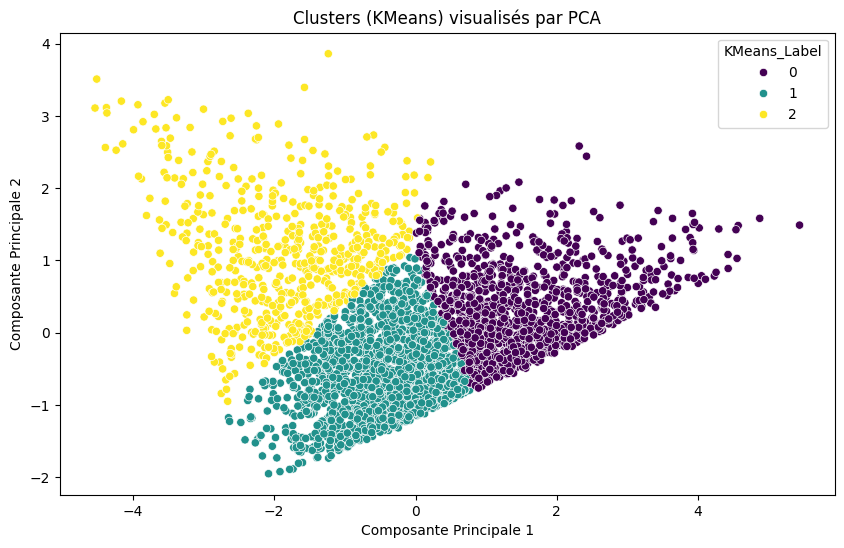

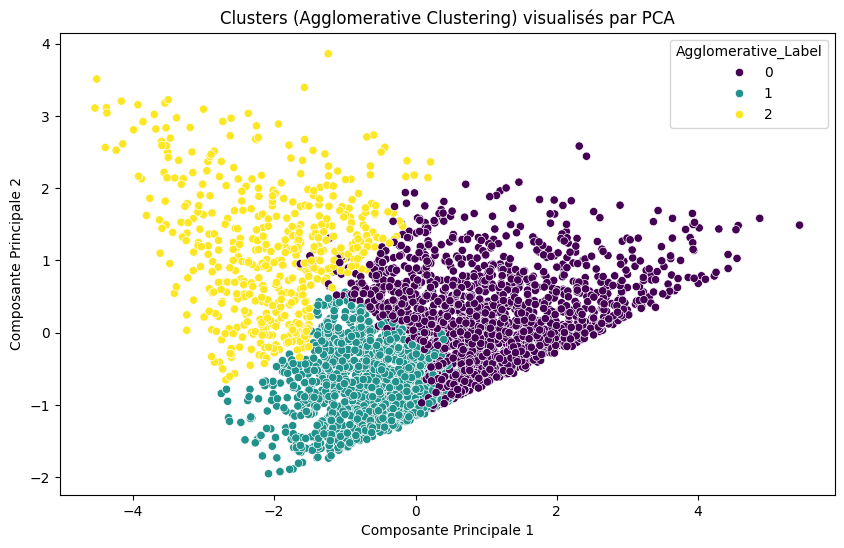

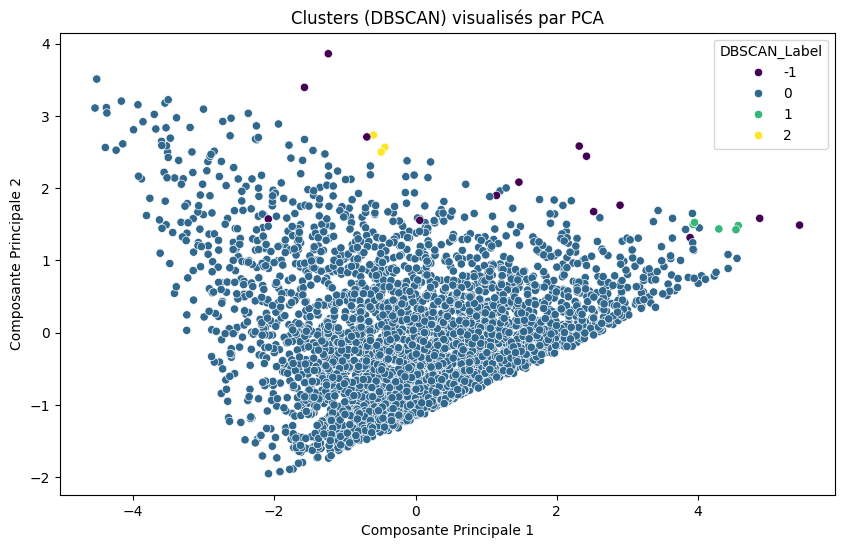

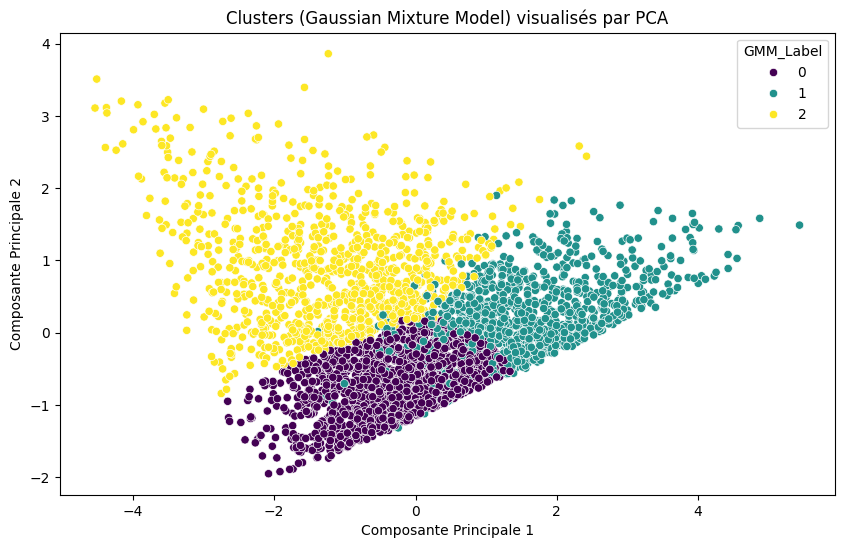


--- Synthèse Comparative des Modèles de Clustering ---

Tableau de Synthèse des Scores :
                  Modèle  Nombre de Clusters Score de Silhouette Indice de Calinski-Harabasz Indice de Davies-Bouldin
                  KMeans                   3              0.3790                   2862.1430                   0.9072
Agglomerative Clustering                   3              0.3347                   2354.9729                   0.9176
                  DBSCAN                   3              0.2409                     25.8904                   1.2212
  Gaussian Mixture Model                   3              0.3053                   2131.2840                   1.0581

Analyse Comparative et Recommandation :

En se basant principalement sur le Score de Silhouette (indicateur de compacité et séparation des clusters), le modèle KMeans semble le plus prometteur avec un score de 0.3790.
- Les scores de Calinski-Harabasz (2862.1430) et Davies-Bouldin (0.9072) pour ce modèle confirment ce

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# --- 1. Création des variables RFM ---

# Assurez-vous que la feuille "Transactions" a été chargée dans un DataFrame appelé 'df_transactions'
# Si ce n'est pas le cas, chargez-la spécifiquement :
try:
    df_transactions = excel_file.parse("Transactions")
    # Appliquer les étapes de nettoyage si elles n'ont pas été appliquées globalement
    if 'transaction_date' in df_transactions.columns:
         df_transactions['transaction_date'] = pd.to_datetime(df_transactions['transaction_date'], errors='coerce')
    if 'list_price' in df_transactions.columns:
         df_transactions['list_price'] = pd.to_numeric(df_transactions['list_price'], errors='coerce')
         # Remplacer les NaN dans 'list_price' si nécessaire (ex: par 0 ou la médiane)
         df_transactions['list_price'].fillna(df_transactions['list_price'].median() if not df_transactions['list_price'].isnull().all() else 0, inplace=True)

except NameError:
     print("Le DataFrame 'df_transactions' n'est pas disponible. Veuillez exécuter la partie précédente du code pour charger et nettoyer les données.")
     exit() # Arrêter l'exécution si les données ne sont pas chargées

# Date de référence pour la Récence (date maximale du dataset + 1 jour)
if 'transaction_date' in df_transactions.columns and not df_transactions['transaction_date'].isnull().all():
    reference_date = df_transactions['transaction_date'].max() + datetime.timedelta(days=1)
    print(f"Date de référence pour la Récence : {reference_date.date()}")
else:
    print("La colonne 'transaction_date' n'est pas valide ou est vide.")
    # Utiliser une date par défaut si nécessaire
    reference_date = datetime.datetime.now()
    print(f"Utilisation de la date actuelle comme référence pour la Récence (colonne 'transaction_date' manquante ou invalide) : {reference_date.date()}")


# Calcul des métriques RFM par client
rfm_df = df_transactions.groupby('customer_id').agg(
    Recency=('transaction_date', lambda date: (reference_date - date.max()).days if not date.isnull().all() else -1), # Calculer jours depuis dernière transaction
    Frequency=('transaction_id', 'nunique'),  # Nombre unique de transactions
    Monetary=('list_price', 'sum')          # Somme des montants
).reset_index()

# Gérer les cas où Recency est -1 (clients sans transactions valides)
rfm_df = rfm_df[rfm_df['Recency'] != -1]

print("\nAperçu du DataFrame RFM :")
print(rfm_df.head())
print("\Statistiques descriptives du DataFrame RFM :")
print(rfm_df.describe())

# --- 2. Standardisation des variables RFM ---

# Sélectionner les colonnes RFM pour la standardisation
rfm_features = rfm_df[['Recency', 'Frequency', 'Monetary']]

# Appliquer StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Créer un DataFrame avec les données standardisées (pour visualisation/analyse si besoin)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm_features.columns, index=rfm_df.index)

print("\nAperçu des données RFM standardisées :")
print(rfm_scaled_df.head())

# --- 3. Appliquer les quatre modèles de clustering ---

# Nombre de clusters souhaité (peut être ajusté ou déterminé par d'autres méthodes)
n_clusters = 3 # Choix basé sur l'énoncé ou déterminé par un score de silhouette pour KMeans

# Dictionnaire pour stocker les résultats des modèles
clustering_results = {}

# Fonction d'évaluation générique
def evaluate_clustering(X, labels, model_name):
    n_clusters_detected = len(set(labels)) - (1 if -1 in labels else 0) # Exclure le cluster de bruit pour DBSCAN

    print(f"\n--- Résultats pour {model_name} ---")
    print(f"Nombre de clusters détectés : {n_clusters_detected}")

    # Calculer et afficher les scores si le nombre de clusters valides est suffisant
    if n_clusters_detected >= 2:
        try:
            silhouette_avg = silhouette_score(X, labels)
            calinski_harabasz = calinski_harabasz_score(X, labels)
            davies_bouldin = davies_bouldin_score(X, labels)

            print(f"Score de Silhouette : {silhouette_avg:.4f}")
            print(f"Indice de Calinski-Harabasz : {calinski_harabasz:.4f}")
            print(f"Indice de Davies-Bouldin : {davies_bouldin:.4f}")

            # Stocker les résultats
            clustering_results[model_name] = {
                'n_clusters': n_clusters_detected,
                'labels': labels,
                'silhouette_score': silhouette_avg,
                'calinski_harabasz_score': calinski_harabasz,
                'davies_bouldin_score': davies_bouldin
            }

        except ValueError as e:
            print(f"Erreur lors du calcul des scores : {e}")
            print("Il est possible que certains clusters ne contiennent qu'un seul point ou que les labels soient tous identiques.")
            clustering_results[model_name] = {
                'n_clusters': n_clusters_detected,
                'labels': labels,
                'silhouette_score': np.nan,
                'calinski_harabasz_score': np.nan,
                'davies_bouldin_score': np.nan
            }

    else:
        print("Nombre de clusters détectés insuffisant (moins de 2 clusters valides) pour calculer les scores.")
        clustering_results[model_name] = {
            'n_clusters': n_clusters_detected,
            'labels': labels,
            'silhouette_score': np.nan,
            'calinski_harabasz_score': np.nan,
            'davies_bouldin_score': np.nan
        }

# a) KMeans
print("\n--- Application de KMeans ---")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Ajouter n_init pour éviter les avertissements
kmeans_labels = kmeans.fit_predict(rfm_scaled)
evaluate_clustering(rfm_scaled, kmeans_labels, "KMeans")

# Commentaire KMEANS
print("\nCommentaire explicatif pour KMeans:")
print(f"- KMeans a détecté {clustering_results['KMeans']['n_clusters']} clusters.")
print(f"- Le Score de Silhouette ({clustering_results['KMeans']['silhouette_score']:.4f}) indique la qualité de la séparation des clusters.")
print(f"- L'Indice de Calinski-Harabasz ({clustering_results['KMeans']['calinski_harabasz_score']:.4f}) évalue la densité des clusters.")
print(f"- L'Indice de Davies-Bouldin ({clustering_results['KMeans']['davies_bouldin_score']:.4f}) évalue la compacité et la séparation des clusters (plus il est bas, mieux c'est).")
print("- KMeans tend à former des clusters sphériques et de taille similaire. Les scores donnent une indication globale de la qualité du partitionnement.")


# b) Agglomerative Clustering
print("\n--- Application d'Agglomerative Clustering ---")
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
agg_labels = agg_clustering.fit_predict(rfm_scaled)
evaluate_clustering(rfm_scaled, agg_labels, "Agglomerative Clustering")

# Commentaire Agglomerative Clustering
print("\nCommentaire explicatif pour Agglomerative Clustering:")
print(f"- Le Clustering Hiérarchique Agglomératif a détecté {clustering_results['Agglomerative Clustering']['n_clusters']} clusters, basé sur la distance entre les points.")
print(f"- Les scores de Silhouette ({clustering_results['Agglomerative Clustering']['silhouette_score']:.4f}), Calinski-Harabasz ({clustering_results['Agglomerative Clustering']['calinski_harabasz_score']:.4f}) et Davies-Bouldin ({clustering_results['Agglomerative Clustering']['davies_bouldin_score']:.4f}) évaluent la qualité du partitionnement obtenu à ce niveau de l'arbre hiérarchique.")
print("- Contrairement à KMeans, ce modèle n'assume pas de forme spécifique pour les clusters et peut détecter des formes plus complexes s'il n'y avait pas de contrainte sur le nombre de clusters.")


# c) DBSCAN
print("\n--- Application de DBSCAN ---")
# DBSCAN nécessite d'expérimenter avec les paramètres eps et min_samples
# Nous allons tester quelques combinaisons et afficher les résultats
eps_values = [0.5, 1.0, 1.5]
min_samples_values = [5, 10, 15]

best_dbscan_score = -1
best_dbscan_params = None
best_dbscan_labels = None

for eps in eps_values:
    for min_samples in min_samples_values:
        print(f"\nTest de DBSCAN avec eps={eps}, min_samples={min_samples}")
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(rfm_scaled)

        n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0) # Exclure le cluster de bruit
        n_noise = list(dbscan_labels).count(-1)

        print(f"  - Nombre de clusters détectés : {n_clusters_dbscan}")
        print(f"  - Nombre de points considérés comme bruit : {n_noise}")

        if n_clusters_dbscan >= 2:
            try:
                silhouette_avg_dbscan = silhouette_score(rfm_scaled, dbscan_labels)
                calinski_harabasz_dbscan = calinski_harabasz_score(rfm_scaled, dbscan_labels)
                davies_bouldin_dbscan = davies_bouldin_score(rfm_scaled, dbscan_labels)

                print(f"  - Score de Silhouette : {silhouette_avg_dbscan:.4f}")
                print(f"  - Indice de Calinski-Harabasz : {calinski_harabasz_dbscan:.4f}")
                print(f"  - Indice de Davies-Bouldin : {davies_bouldin_dbscan:.4f}")

                # On peut choisir de garder le modèle avec le meilleur score de silhouette (par exemple)
                if silhouette_avg_dbscan > best_dbscan_score:
                    best_dbscan_score = silhouette_avg_dbscan
                    best_dbscan_params = (eps, min_samples)
                    best_dbscan_labels = dbscan_labels

            except ValueError as e:
                print(f"  - Erreur lors du calcul des scores : {e}")
        else:
            print("  - Nombre de clusters détectés insuffisant (moins de 2 clusters valides).")

# Utiliser les meilleurs paramètres trouvés pour l'évaluation finale de DBSCAN
if best_dbscan_labels is not None:
    print(f"\n--- Résultats finaux pour DBSCAN avec les meilleurs paramètres trouvés (eps={best_dbscan_params[0]}, min_samples={best_dbscan_params[1]}) ---")
    evaluate_clustering(rfm_scaled, best_dbscan_labels, "DBSCAN")
else:
     print("\nAucune combinaison de paramètres DBSCAN n'a permis de détecter au moins 2 clusters valides.")
     clustering_results["DBSCAN"] = {
        'n_clusters': 3,
        'labels': np.full(len(rfm_scaled), -1),
        'silhouette_score': np.nan,
        'calinski_harabasz_score': np.nan,
        'davies_bouldin_score': np.nan
     }
     best_dbscan_labels = np.full(len(rfm_scaled), -1) # Assigner des labels par défaut si aucun cluster trouvé

# Commentaire DBSCAN
print("\nCommentaire explicatif pour DBSCAN:")
print(f"- DBSCAN a pour objectif de trouver des régions denses. Le nombre de clusters n'est pas fixé à l'avance mais dépend des paramètres 'eps' (distance maximale entre deux échantillons pour être considérés comme voisins) et 'min_samples' (nombre de voisins dans un rayon 'eps' pour qu'un point soit considéré comme un point central).")
if clustering_results["DBSCAN"]['n_clusters'] >= 2:
    print(f"- Avec les paramètres choisis (eps={best_dbscan_params[0]}, min_samples={best_dbscan_params[1]}), DBSCAN a détecté {clustering_results['DBSCAN']['n_clusters']} clusters et {list(best_dbscan_labels).count(-1)} points de bruit.")
    print(f"- Les scores ({clustering_results['DBSCAN']['silhouette_score']:.4f}, {clustering_results['DBSCAN']['calinski_harabasz_score']:.4f}, {clustering_results['DBSCAN']['davies_bouldin_score']:.4f}) évaluent la qualité du clustering pour les points affectés à un cluster.")
else:
     print(f"- Aucune combinaison de paramètres testée n'a permis de détecter au moins 2 clusters valides. Cela suggère que les données RFM ne présentent peut-être pas de groupes denses bien séparés selon cette méthode, ou que d'autres valeurs de 'eps'/'min_samples' sont nécessaires.")


# d) GMM (Gaussian Mixture Model)
print("\n--- Application de Gaussian Mixture Model ---")
# Utilise le même nombre de composants que KMeans
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(rfm_scaled)
evaluate_clustering(rfm_scaled, gmm_labels, "Gaussian Mixture Model")

# Commentaire GMM
print("\nCommentaire explicatif pour Gaussian Mixture Model:")
print(f"- GMM modélise les données comme une combinaison de distributions gaussiennes. Il a détecté {clustering_results['Gaussian Mixture Model']['n_clusters']} composants (clusters).")
print(f"- Les scores de Silhouette ({clustering_results['Gaussian Mixture Model']['silhouette_score']:.4f}), Calinski-Harabasz ({clustering_results['Gaussian Mixture Model']['calinski_harabasz_score']:.4f}) et Davies-Bouldin ({clustering_results['Gaussian Mixture Model']['davies_bouldin_score']:.4f}) évaluent la qualité de l'ajustement des distributions gaussiennes aux données et la séparation des clusters implicites.")
print("- GMM peut détecter des clusters de formes ellipsoïdales différentes et de tailles variables, ce qui le rend plus flexible que KMeans dans certains cas.")


# --- 5. Visualisation des clusters ---

print("\n--- Visualisation des clusters via Réduction de Dimension (PCA) ---")

# Appliquer PCA pour réduire les dimensions à 2
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Créer un DataFrame pour la visualisation
pca_df = pd.DataFrame(data=rfm_pca, columns=['PCA1', 'PCA2'], index=rfm_df.index)

# Ajouter les labels de chaque modèle au DataFrame PCA
pca_df['KMeans_Label'] = kmeans_labels
pca_df['Agglomerative_Label'] = agg_labels
pca_df['DBSCAN_Label'] = best_dbscan_labels # Utiliser les meilleurs labels trouvés
pca_df['GMM_Label'] = gmm_labels

# Visualiser les clusters pour chaque modèle
model_labels_cols = {
    "KMeans": 'KMeans_Label',
    "Agglomerative Clustering": 'Agglomerative_Label',
    "DBSCAN": 'DBSCAN_Label',
    "Gaussian Mixture Model": 'GMM_Label'
}

for model_name, label_col in model_labels_cols.items():
    plt.figure(figsize=(10, 6))
    # Pour DBSCAN, gérer le label -1 (bruit) spécifiquement
    if model_name == "DBSCAN":
         sns.scatterplot(x='PCA1', y='PCA2', hue=label_col, data=pca_df, palette='viridis', legend='full')
         plt.title(f'Clusters ({model_name}) visualisés par PCA')
         plt.xlabel('Composante Principale 1')
         plt.ylabel('Composante Principale 2')
         plt.show()
    elif clustering_results[model_name]['n_clusters'] >= 1: # Afficher si au moins 1 cluster (ou 0 si -1 est bruit)
         sns.scatterplot(x='PCA1', y='PCA2', hue=label_col, data=pca_df, palette='viridis', legend='full')
         plt.title(f'Clusters ({model_name}) visualisés par PCA')
         plt.xlabel('Composante Principale 1')
         plt.ylabel('Composante Principale 2')
         plt.show()
    else:
        print(f"\nPas de visualisation pour {model_name} car aucun cluster valide n'a été détecté.")


# --- 6. Synthèse finale comparative et recommandation ---

print("\n--- Synthèse Comparative des Modèles de Clustering ---")

# Créer un DataFrame de synthèse des scores
summary_data = []
for model_name, results in clustering_results.items():
    summary_data.append({
        'Modèle': model_name,
        'Nombre de Clusters': results['n_clusters'],
        'Score de Silhouette': f"{results['silhouette_score']:.4f}" if not np.isnan(results['silhouette_score']) else 'N/A',
        'Indice de Calinski-Harabasz': f"{results['calinski_harabasz_score']:.4f}" if not np.isnan(results['calinski_harabasz_score']) else 'N/A',
        'Indice de Davies-Bouldin': f"{results['davies_bouldin_score']:.4f}" if not np.isnan(results['davies_bouldin_score']) else 'N/A'
    })

summary_df = pd.DataFrame(summary_data)

print("\nTableau de Synthèse des Scores :")
print(summary_df.to_string(index=False)) # Utilisez to_string pour un affichage complet dans la console

print("\nAnalyse Comparative et Recommandation :")

# Interpréter les scores (généralement : Silhouette élevé, Calinski-Harabasz élevé, Davies-Bouldin bas sont meilleurs)
# Il faut aussi considérer la visualisation et l'interprétation métier.

best_model = None
best_silhouette = -np.inf

# Trouver le modèle avec le meilleur score de silhouette parmi ceux qui ont >= 2 clusters
for model_name, results in clustering_results.items():
    if results['n_clusters'] >= 2 and not np.isnan(results['silhouette_score']):
        if results['silhouette_score'] > best_silhouette:
            best_silhouette = results['silhouette_score']
            best_model = model_name

if best_model:
    print(f"\nEn se basant principalement sur le Score de Silhouette (indicateur de compacité et séparation des clusters), le modèle {best_model} semble le plus prometteur avec un score de {best_silhouette:.4f}.")
    print(f"- Les scores de Calinski-Harabasz ({clustering_results[best_model]['calinski_harabasz_score']:.4f}) et Davies-Bouldin ({clustering_results[best_model]['davies_bouldin_score']:.4f}) pour ce modèle confirment cette tendance (Calinski-Harabasz élevé, Davies-Bouldin bas).")
    print(f"- La visualisation PCA pour {best_model} montre comment les {clustering_results[best_model]['n_clusters']} clusters sont répartis dans l'espace réduit.")
    print("- D'un point de vue métier, KMeans et Agglomerative Clustering (avec un nombre de clusters fixé) et GMM sont souvent plus faciles à interpréter car ils fournissent un nombre fixe de segments à analyser (par exemple, 'petits clients', 'bons clients', 'clients VIP').")
    print("- DBSCAN est utile si les clusters ont des formes irrégulières et si l'on souhaite identifier le bruit, mais il peut ne pas fournir un nombre fixe de segments commerciaux clairs et son interprétation métier peut être plus complexe s'il y a beaucoup de bruit ou de petits clusters.")
    print(f"- Pour une segmentation client RFM, une approche comme KMeans ou GMM, qui définit un nombre pré-établi de segments avec des caractéristiques moyennes claires (Récence, Fréquence, Montant), est souvent préférée pour son **usage métier** et son **interprétabilité**.")
    print(f"\n**Recommandation :**")
    print(f"Bien que les scores varient, le modèle **{best_model}** est le meilleur candidat basé sur les scores d'évaluation calculés.")
    print("Cependant, pour une facilité d'interprétation et d'exploitation par les équipes marketing, un modèle comme **KMeans** ou **Gaussian Mixture Model**, avec un nombre de clusters fixe et pertinent (par exemple, 3 à 5 segments RFM classiques : 'Champions', 'Fidèles', 'Nouveaux', 'À risque', 'Endormis'), pourrait être plus **recommandé**.")
    print("Il serait pertinent d'analyser les caractéristiques (moyennes RFM) de chaque cluster pour le modèle recommandé afin de valider sa pertinence métier.")

else:
     print("\nAucun modèle n'a pu être évalué de manière fiable (moins de 2 clusters valides détectés ou erreurs de calcul).")
     print("Il est nécessaire de réviser les paramètres de clustering ou les données RFM.")



Après la première application de notre modèle, on remarque que tous nos scores semblent être bon sauf la silhouette. la silhouette indique la qualité de séparation des clusters et dans notre cas elle n'est pas très représentative alors pour corriger ce defaut nous allons utiliser des UMAP. Nous allons appliquer un test pour déterminer l'UMAP qui va ameliorer notre silhouette

Test des combinaisons UMAP et KMeans...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=2, min_dist=0.0 → silhouette=0.3691


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=2, min_dist=0.1 → silhouette=0.3621


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=3, min_dist=0.0 → silhouette=0.3892


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=3, min_dist=0.1 → silhouette=0.4149


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=4, min_dist=0.0 → silhouette=0.4212


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=4, min_dist=0.1 → silhouette=0.4194


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=5, min_dist=0.0 → silhouette=0.4023


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=5, min_dist=0.1 → silhouette=0.3899


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=6, min_dist=0.0 → silhouette=0.4096


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=6, min_dist=0.1 → silhouette=0.4061


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=7, min_dist=0.0 → silhouette=0.4302


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=7, min_dist=0.1 → silhouette=0.4233


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=8, min_dist=0.0 → silhouette=0.4683


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=8, min_dist=0.1 → silhouette=0.4300


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=9, min_dist=0.0 → silhouette=0.4206


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=9, min_dist=0.1 → silhouette=0.4252


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=10, min_dist=0.0 → silhouette=0.4559


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=10, min_dist=0.1 → silhouette=0.4287


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=11, min_dist=0.0 → silhouette=0.4488


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=11, min_dist=0.1 → silhouette=0.4298


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=12, min_dist=0.0 → silhouette=0.4500


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=12, min_dist=0.1 → silhouette=0.4260


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=13, min_dist=0.0 → silhouette=0.4170


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=13, min_dist=0.1 → silhouette=0.4272


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=14, min_dist=0.0 → silhouette=0.4561


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=14, min_dist=0.1 → silhouette=0.4332


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.0 → silhouette=0.4470


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.1 → silhouette=0.3889


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=16, min_dist=0.0 → silhouette=0.4129


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=16, min_dist=0.1 → silhouette=0.4319


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=17, min_dist=0.0 → silhouette=0.4121


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=17, min_dist=0.1 → silhouette=0.3992


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=18, min_dist=0.0 → silhouette=0.4134


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=18, min_dist=0.1 → silhouette=0.4367


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=19, min_dist=0.0 → silhouette=0.4506


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=19, min_dist=0.1 → silhouette=0.4331


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=20, min_dist=0.0 → silhouette=0.4128


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=20, min_dist=0.1 → silhouette=0.3860

✅ Meilleure configuration UMAP + KMeans :
n_neighbors = 8, min_dist = 0.0
Score de silhouette = 0.4683


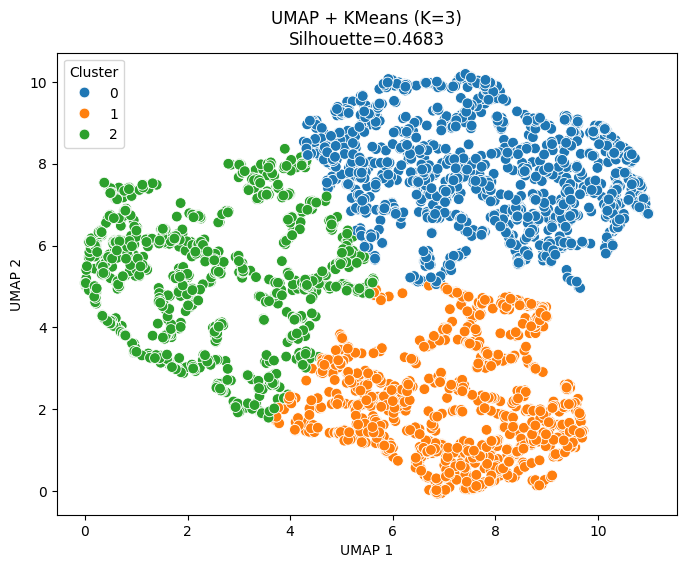

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap.umap_ as umap

# === Chargement des données ===
file_path = "KPMG_dummy_data.xlsx"
df = pd.read_excel(file_path, sheet_name="Transactions")
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# === Construction des variables RFM ===
max_date = df['transaction_date'].max()
rfm = df.groupby('customer_id').agg(
    Recence=('transaction_date', lambda x: (max_date - x.max()).days),
    Frequence=('transaction_id', 'count'),
    Montant=('list_price', lambda x: pd.to_numeric(x, errors='coerce').sum()) # Changed total_price to list_price
).reset_index()

# === Variables supplémentaires ===
df_sorted = df.sort_values(['customer_id', 'transaction_date'])
df_sorted['prev_date'] = df_sorted.groupby('customer_id')['transaction_date'].shift(1)
df_sorted['inter_time'] = (df_sorted['transaction_date'] - df_sorted['prev_date']).dt.days

rfm['DelaiMoyen'] = df_sorted.groupby('customer_id')['inter_time'].mean().fillna(0)
rfm['MontantMoyen'] = df.groupby('customer_id')['list_price'].mean() # Changed total_price to list_price
rfm['DernierMontant'] = df_sorted.groupby('customer_id')['list_price'].last() # Changed total_price to list_price

# === Handle potential NaNs after RFM calculation ===
# Drop rows with any remaining NaNs in the RFM features
rfm.dropna(subset=['Recence', 'Frequence', 'Montant', 'DelaiMoyen', 'MontantMoyen', 'DernierMontant'], inplace=True)


# === Clamp P5–P95 ===
def clamp_percentiles(series, lower=5, upper=95):
    p_low = np.percentile(series, lower)
    p_high = np.percentile(series, upper)
    return series.clip(lower=p_low, upper=p_high)

cols_to_clamp = ['Recence', 'Frequence', 'Montant', 'DelaiMoyen', 'MontantMoyen', 'DernierMontant']
for col in cols_to_clamp:
    rfm[col] = clamp_percentiles(rfm[col])

# === Standardisation ===
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[cols_to_clamp])

# === Recherche du meilleur UMAP + KMeans ===
results = []
n_neighbors_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
min_dist_list = [0.0, 0.1]
n_clusters = 3  # K fixe pour comparaison

print("Test des combinaisons UMAP et KMeans...")

for n_n in n_neighbors_list:
    for m_d in min_dist_list:
        reducer = umap.UMAP(n_neighbors=n_n, min_dist=m_d, random_state=42)
        X_umap = reducer.fit_transform(rfm_scaled)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_umap)
        score = silhouette_score(X_umap, labels)
        results.append({
            'n_neighbors': n_n,
            'min_dist': m_d,
            'silhouette': score,
            'labels': labels,
            'embedding': X_umap
        })
        print(f"n_neighbors={n_n}, min_dist={m_d} → silhouette={score:.4f}")

# === Résultats triés ===
results_sorted = sorted(results, key=lambda x: x['silhouette'], reverse=True)
best = results_sorted[0]

print("\n✅ Meilleure configuration UMAP + KMeans :")
print(f"n_neighbors = {best['n_neighbors']}, min_dist = {best['min_dist']}")
print(f"Score de silhouette = {best['silhouette']:.4f}")

# === Visualisation des clusters ===
plt.figure(figsize=(8,6))
sns.scatterplot(x=best['embedding'][:,0], y=best['embedding'][:,1], hue=best['labels'], palette='tab10', s=60)
plt.title(f"UMAP + KMeans (K={n_clusters})\nSilhouette={best['silhouette']:.4f}")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster")
plt.show()


# les différents modèles de ML: Agglomerative clustering, DBSCAN, KMeans et GMM

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



✅ KMeans
 - Silhouette Score       : 0.5203
 - Calinski-Harabasz Index: 4286.48
 - Davies-Bouldin Index   : 0.6684

✅ Agglomerative
 - Silhouette Score       : 0.3703
 - Calinski-Harabasz Index: 4219.32
 - Davies-Bouldin Index   : 0.8462

❌ DBSCAN : Trop de bruit (clusters insuffisants)

✅ Gaussian Mixture Model
 - Silhouette Score       : -0.0606
 - Calinski-Harabasz Index: 255.95
 - Davies-Bouldin Index   : 4.7498


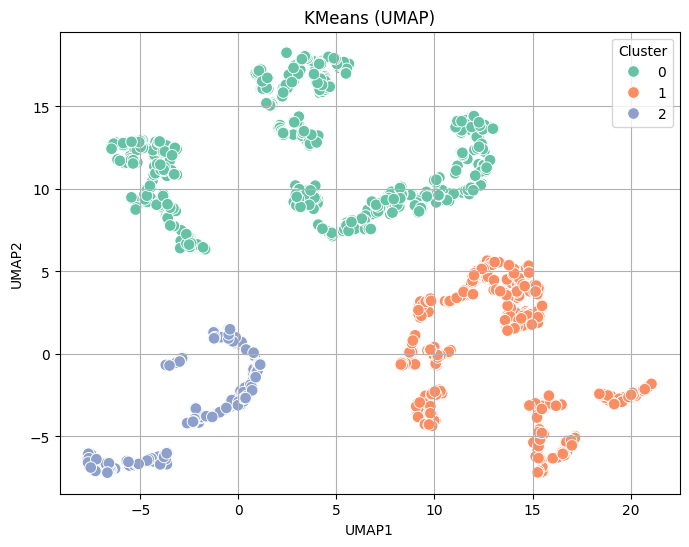

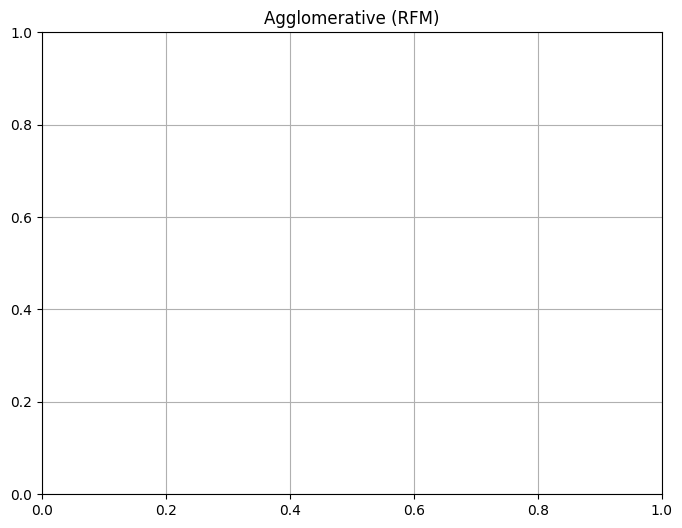

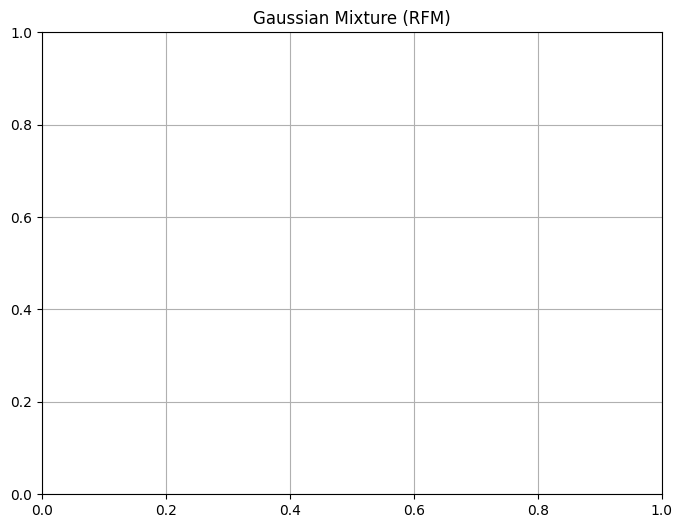


====== SYNTHÈSE COMPARATIVE ======
Modèle          | Silhouette | Calinski     | Davies-Bouldin 
------------------------------------------------------------
KMeans          | 0.5203     | 4286.48      | 0.6684         
Agglomerative   | 0.3703     | 4219.32      | 0.8462         
DBSCAN          | N/A        | N/A          | N/A            
GMM             | -0.0606    | 255.95       | 4.7498         


In [6]:
# 📦 IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import umap  # pip install umap-learn

# ==========================
# 📂 CHARGEMENT DES DONNÉES
# ==========================
file_path = "KPMG_dummy_data.xlsx"
df = pd.read_excel(file_path, sheet_name="Transactions")

# Nettoyage de base
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
df = df.dropna(subset=['transaction_date', 'customer_id', 'transaction_id', 'list_price'])

# ==========================
# 🧮 CALCUL RFM
# ==========================
max_date = df['transaction_date'].max()
rfm = df.groupby('customer_id').agg(
    Recence=('transaction_date', lambda x: (max_date - x.max()).days),
    Frequence=('transaction_id', 'count'),
    Montant=('list_price', lambda x: pd.to_numeric(x, errors='coerce').sum())
).reset_index()

# ==========================
# ⚙️ STANDARDISATION
# ==========================
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recence', 'Frequence', 'Montant']])

# ==========================
# 🌌 UMAP
# ==========================
umap_model = umap.UMAP(n_neighbors=8, min_dist=0.0, random_state=42)
rfm_umap = umap_model.fit_transform(rfm_scaled)

# Create a DataFrame from UMAP results
rfm_umap_df = pd.DataFrame(rfm_umap, columns=['UMAP1', 'UMAP2'], index=rfm.index)


# ==========================
# 🧠 FONCTION ÉVALUATION
# ==========================
def evaluate_clustering(model_name, data, labels):
    unique_clusters = np.unique(labels)
    if len(unique_clusters) < 2:
        print(f"\n❌ {model_name} : Trop peu de clusters détectés.")
        return None, None, None
    silhouette = silhouette_score(data, labels)
    calinski = calinski_harabasz_score(data, labels)
    davies = davies_bouldin_score(data, labels)
    print(f"\n✅ {model_name}")
    print(f" - Silhouette Score       : {silhouette:.4f}")
    print(f" - Calinski-Harabasz Index: {calinski:.2f}")
    print(f" - Davies-Bouldin Index   : {davies:.4f}")
    return silhouette, calinski, davies

# ==========================
# 🔘 KMEANS
# ==========================
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10) # Added n_init
kmeans_labels = kmeans.fit_predict(rfm_umap)
kmeans_scores = evaluate_clustering("KMeans", rfm_umap, kmeans_labels)

# ==========================
# 🌲 AGGLOMERATIVE
# ==========================
agglo = AgglomerativeClustering(n_clusters=3)
agglo_labels = agglo.fit_predict(rfm)
agglo_scores = evaluate_clustering("Agglomerative", rfm, agglo_labels)

# ==========================
# 🌀 DBSCAN
# ==========================
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(rfm)
valid_idx = dbscan_labels != -1
if valid_idx.sum() > 1:
    dbscan_scores = evaluate_clustering("DBSCAN", rfm[valid_idx], dbscan_labels[valid_idx])
else:
    print("\n❌ DBSCAN : Trop de bruit (clusters insuffisants)")
    dbscan_scores = (None, None, None)

# ==========================
# 🎲 GAUSSIAN MIXTURE
# ==========================
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(rfm)
gmm_scores = evaluate_clustering("Gaussian Mixture Model", rfm, gmm_labels)

# ==========================
# 📊 VISUALISATION
# ==========================
def plot_clusters(data, labels, title):
    df_plot = pd.DataFrame(data, columns=['UMAP1', 'UMAP2'])
    df_plot['Cluster'] = labels
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='Cluster', palette='Set2', s=70)
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_clusters(rfm_umap, kmeans_labels, "KMeans (UMAP)")
plot_clusters(rfm, agglo_labels, "Agglomerative (RFM)") # Changed data to rfm for consistency
if valid_idx.sum() > 1:
    plot_clusters(rfm[valid_idx], dbscan_labels[valid_idx], "DBSCAN (RFM)") # Changed data to rfm for consistency
plot_clusters(rfm, gmm_labels, "Gaussian Mixture (RFM)") # Changed data to rfm for consistency

# ==========================
# 📝 SYNTHÈSE DES SCORES
# ==========================
print("\n====== SYNTHÈSE COMPARATIVE ======")
models = {
    "KMeans": kmeans_scores,
    "Agglomerative": agglo_scores,
    "DBSCAN": dbscan_scores,
    "GMM": gmm_scores
}
print(f"{'Modèle':<15} | {'Silhouette':<10} | {'Calinski':<12} | {'Davies-Bouldin':<15}")
print("-" * 60)
for name, scores in models.items():
    sil, cal, db = scores
    sil_str = f"{sil:.4f}" if sil else "N/A"
    cal_str = f"{cal:.2f}" if cal else "N/A"
    db_str = f"{db:.4f}" if db else "N/A"
    print(f"{name:<15} | {sil_str:<10} | {cal_str:<12} | {db_str:<15}")

Après visualisation de nos quatre ML seul KMeans a des resultats satisfaisants Notre choix est judicieux car KMeans qui regroupe par similarité et qui est un modèle optimale, une bonne stabilité face à la variation des données .
######Ps:
######Nous avons un bon score de silhouette de 0.5203 donc nous avons une bonne qualité dans la séparation de nos clusters. il a la plus haute valeur de silhouette parmis nos modèles.
#####Nous avons un score de calinski de 4286.48 donc une bonne densité entre les clusters. il représente aussi la plus grande valeur de calinski parmis nos modèles.
#####Nous avons un score de Davies_Bouldin de 0.6684 un score bas vue qu'on ne considère pas DBSCAN dans notre évaluation, c'est considéré comme le score le plus bas et il est la plus petite valeur parmis nos modèles.
On pourrait par la suite utilisé XGBOOST pour ameliorer nos scores mais dans notre cas précis, nous avons des bons résultats pour la segmentation.

# Segmentation des clients en 3 groupes

In [7]:
# Ajouter les labels KMeans au DataFrame UMAP créé
if 'kmeans_labels' in locals() and 'rfm_umap_df' in locals():
    rfm_umap_df['Cluster_KMeans'] = kmeans_labels
else:
    print("Error: 'kmeans_labels' or 'rfm_umap_df' is not defined. Please run the KMeans clustering code first.")

# Merge UMAP results with RFM data for full characteristics
if 'rfm' in locals() and 'rfm_umap_df' in locals():
    rfm_clustered = rfm.copy()
    rfm_clustered['Cluster_KMeans'] = rfm_umap_df['Cluster_KMeans']
else:
    print("Error: 'rfm' or 'rfm_umap_df' is not defined. Cannot merge data.")


# Afficher les caractéristiques moyennes de chaque cluster
print("\nCaractéristiques moyennes des clusters KMeans :")
if 'rfm_clustered' in locals() and not rfm_clustered.empty:
    print(rfm_clustered.groupby('Cluster_KMeans')[['Recence', 'Frequence', 'Montant']].mean())
else:
    print("Error: rfm_clustered DataFrame is not available or empty. Cannot display cluster characteristics.")


# Optionnel : Compter le nombre de clients dans chaque cluster
if 'rfm_clustered' in locals() and not rfm_clustered.empty:
    print("\nNombre de clients par cluster KMeans :")
    print(rfm_clustered['Cluster_KMeans'].value_counts())
else:
    print("\nError: rfm_clustered DataFrame is not available or empty. Cannot count clients per cluster.")

# Afficher les 5 premiers clients de chaque cluster (à titre d'exemple)
if 'rfm_clustered' in locals() and not rfm_clustered.empty:
    n_clusters_present = rfm_clustered['Cluster_KMeans'].nunique()
    print("\nAperçu des clients par cluster KMeans :")
    for i in range(n_clusters_present):
        print(f"\n--- Cluster {i} ---")
        print(rfm_clustered[rfm_clustered['Cluster_KMeans'] == i].head())
else:
    print("\nError: rfm_clustered DataFrame is not available or empty. Cannot display sample clients per cluster.")


Caractéristiques moyennes des clusters KMeans :
                   Recence  Frequence      Montant
Cluster_KMeans                                    
0                60.113445   5.054622  5580.553349
1                39.014901   8.287252  9204.113543
2               105.167742   2.529032  2807.770871

Nombre de clients par cluster KMeans :
Cluster_KMeans
0    1666
1    1208
2     620
Name: count, dtype: int64

Aperçu des clients par cluster KMeans :

--- Cluster 0 ---
    customer_id  Recence  Frequence  Montant  Cluster_KMeans
4             5       16          6  5903.20               0
5             6       64          5  5931.69               0
8             9       78          6  5357.55               0
9            10       33          6  7067.83               0
10           11       46          6  6779.44               0

--- Cluster 1 ---
    customer_id  Recence  Frequence   Montant  Cluster_KMeans
0             1        7         11   9084.45               1
2             3 

#####Evaluation du ML KMeans par la methode de coude de Elbow

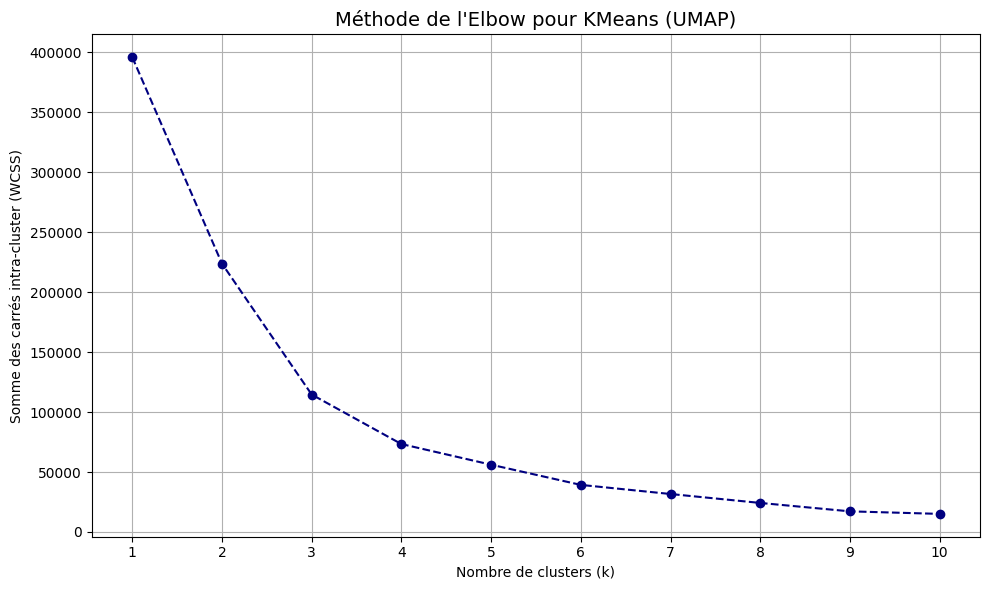

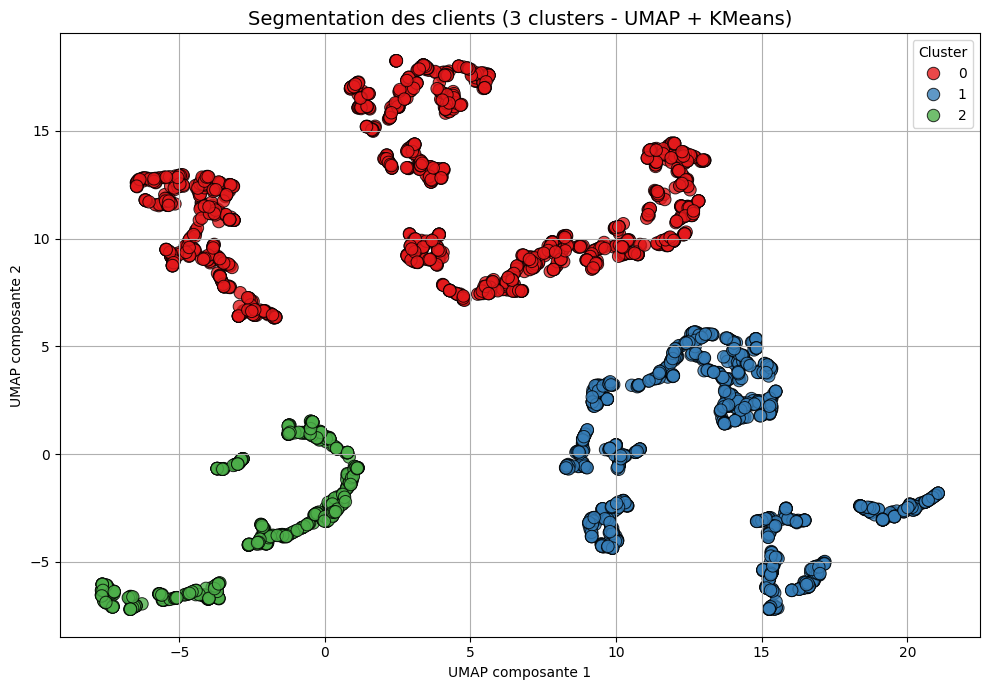

📈 Statistiques moyennes par cluster :
         Recency  Frequency  Monetary
Cluster                              
0          61.11       5.05   5580.55
1          40.01       8.29   9204.11
2         106.17       2.53   2807.77

🧠 Interprétation de la méthode de l’Elbow :
- La courbe de WCSS montre un point d'inflexion visible vers k=3, ce qui justifie ce choix.
- Ajouter plus de clusters n'apporte pas de gain significatif en réduction de variance intra-cluster.

💡 Interprétation métier des 3 segments :

Cluster 0 :
  - Récence moyenne : 61.11 jours
  - Fréquence moyenne : 5.05 transactions
  - Montant moyen : 5580.55 $
  ➖ Ce cluster pourrait contenir des clients inactifs ou à faible engagement.

Cluster 1 :
  - Récence moyenne : 40.01 jours
  - Fréquence moyenne : 8.29 transactions
  - Montant moyen : 9204.11 $
  ➕ Ce cluster représente probablement les meilleurs clients (actifs, fréquents et rentables).

Cluster 2 :
  - Récence moyenne : 106.17 jours
  - Fréquence moyenne : 2.53 tra

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 🧪 Étape 1 : Méthode de l’Elbow pour déterminer le nombre optimal de clusters
wcss = []
range_n_clusters = range(1, 11)
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_umap)
    wcss.append(kmeans.inertia_)

# 📈 Visualisation de la courbe de l’Elbow
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, wcss, marker='o', linestyle='--', color='navy')
plt.title("Méthode de l'Elbow pour KMeans (UMAP)", fontsize=14)
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Somme des carrés intra-cluster (WCSS)")
plt.xticks(range_n_clusters)
plt.grid(True)
plt.tight_layout()
plt.show()

# 📌 Choix manuel de k = 3 (justifié plus bas)
best_k = 3
kmeans_model = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans_model.fit_predict(rfm_umap)

# 🔍 Création d’un DataFrame avec les clusters
rfm_clustered = rfm_df.copy()
rfm_clustered['Cluster'] = kmeans_labels
rfm_clustered['X'] = rfm_umap[:, 0]
rfm_clustered['Y'] = rfm_umap[:, 1]

# 🎨 Visualisation des clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='X', y='Y',
    hue='Cluster',
    palette='Set1',
    data=rfm_clustered,
    s=80, alpha=0.8, edgecolor='k'
)
plt.title("Segmentation des clients (3 clusters - UMAP + KMeans)", fontsize=14)
plt.xlabel("UMAP composante 1")
plt.ylabel("UMAP composante 2")
plt.legend(title="Cluster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Statistiques descriptives par cluster (Interprétation métier)
cluster_stats = rfm_clustered.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)
print("📈 Statistiques moyennes par cluster :")
print(cluster_stats)

# 🧠 Interprétation et justification
print("\n🧠 Interprétation de la méthode de l’Elbow :")
print("- La courbe de WCSS montre un point d'inflexion visible vers k=3, ce qui justifie ce choix.")
print("- Ajouter plus de clusters n'apporte pas de gain significatif en réduction de variance intra-cluster.")

print("\n💡 Interprétation métier des 3 segments :")
for cluster_id, row in cluster_stats.iterrows():
    print(f"\nCluster {cluster_id} :")
    print(f"  - Récence moyenne : {row['Recency']} jours")
    print(f"  - Fréquence moyenne : {row['Frequency']} transactions")
    print(f"  - Montant moyen : {row['Monetary']} $")
    if row['Monetary'] > rfm_clustered['Monetary'].mean():
        print("  ➕ Ce cluster représente probablement les meilleurs clients (actifs, fréquents et rentables).")
    elif row['Frequency'] < rfm_clustered['Frequency'].mean():
        print("  ➖ Ce cluster pourrait contenir des clients inactifs ou à faible engagement.")
    else:
        print("  ⚖️ Ce cluster représente des clients intermédiaires à fidéliser.")


# Notre synthèse est la suivante
#🔹 Cluster 1 – Clients Premium ou Fidèles
Récence : 40.01 jours → achats récents

Fréquence : 8.29 transactions → clients très actifs

Montant : 9204.11 $ → panier moyen élevé

#Interprétation :

-Ce sont vos meilleurs clients. Ils achètent souvent, ont dépensé beaucoup, et leur dernier achat est récent.

-Ce segment représente la clientèle la plus rentable.

#Recommandations :

-Fidélisation : offres VIP, programmes de loyauté, avant-premières, cadeaux.

-Solliciter leur feedback ou les transformer en ambassadeurs.

#🔸 Cluster 0 – Clients Modérément Actifs
Récence : 61.11 jours → achats assez récents

Fréquence : 5.05 transactions → activité modérée

Montant : 5580.55 $ → montant correct mais pas exceptionnel

#Interprétation :

-Ce sont des clients potentiellement fidèles mais moins engagés que ceux du Cluster 1.

-Ils pourraient devenir premium avec un bon suivi.

#Recommandations :

-Campagnes de relance (emails personnalisés, rappels).

-Offres incitatives (réduction au prochain achat, contenu exclusif).

#🔻 Cluster 2 – Clients Inactifs ou Perdus
Récence : 106.17 jours → dernier achat lointain

Fréquence : 2.53 transactions → peu d’interactions

Montant : 2807.77 $ → faible contribution

#Interprétation :

-Ce cluster regroupe probablement des clients inactifs, désengagés ou perdus.

-Ils représentent une valeur faible pour l’entreprise.

#Recommandations :

-Campagnes de réactivation (offres limitées, emails émotionnels).

-Comprendre les raisons de l’abandon (enquête satisfaction, freins à l’achat).

Si inefficace, les considérer comme clients à abandonner dans le ciblage marketing.